## Comparar aeropendulo com solução analítica de segunda ordem

A equação diferencial do aeropendulo com atrito estático e dinâmico é:
$$m l^2 \frac{d^2\theta}{dt^2} = -m g l sin(\theta)- b \frac{d\theta}{dt}+l ( H(t)-\tau_a/l ) $$
O ângulo de equilibrio no regime estacionário é:
$$sin(\theta_0)=\frac{H-\tau_a/l}{m g} $$
Para a força de propulsão $H$ assumimos um modelo de ordem zero: uma proporcionalidade direta com coeficiente constante $C_L$ (lift coefficient) entre o valor de $u(t)=pwm(t)$ na saida do controlador, e a força de propulsão $H$ da hélice:
$$H(t)=C_L \cdot pwm(t) = C_L \cdot u(t)$$.
É complicado (mas não impossível) obter uma estimativa da força de propulsão da hélice a partir de um modelo teórico. Para estimar a magnitude de $C_L$ aplicamos um argumento heurístico: num minidrone com quatro motores dc mais hélice cada um tem que suportar pelo menos um quarto do peso do drone. Assim,
$$C_L \approx 0.25 m g / pwm_{max}$$
Para avaliar a dinâmica na próximidade do ponto de equilibrio aproximamos o termo não-linear $sin(\theta)$ pela série de Taylor de primeira ordem na próximidade do ângulo de equilíbrio:
$sin(\theta) \approx sin(\theta_0)+cos(\theta_0) \cdot (\theta-\theta_0)$
A versão linearizada da equação do aeropendulo:
$$\frac{1}{cos(\theta_0)}\frac{l}{g} \frac{d^2\theta}{dt^2} + \frac{1}{cos(\theta_0)}\frac{b}{mgl}\frac{d\theta}{dt}+\theta=\frac{C_L}{m g cos(\theta_0)} pwm(t)- \left( \frac{\tau_a/l}{m g cos(\theta_0)} + tan(\theta_0)+ \theta_0 \right )$$
Em geral, a equação linear para sistemas de segunda ordem è: 
$$\tau_s^2 \frac{d^2y}{dt^2} + 2 \zeta \tau_s \frac{dy}{dt} + y = K_p \, u\left(t-\theta_p \right)$$

Por comparação:

- Second order time constant $\tau_s$
$$\tau_s=\sqrt{\frac{1}{cos(\theta_0)}\frac{l}{g}}=\frac{T}{\sqrt{cos(\theta_0)}}$$
- Damping factor $\zeta$
$$\zeta=\frac{b}{2ml\sqrt{l cos(\theta_0)}}$$
- Process gain $K_p$
$$K_p=\frac{C_L}{m g cos(\theta_0)} $$

## Estimar valores numéricos

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def parameters(l,theta0,b,m):
    # input:
    # l,theta0,b,m
    # Kp = process gain
    # taus = second order time constant
    # zeta = damping factor
    g=9.81
    tau = np.sqrt(l/(g*np.cos(theta0)))
    zeta = b/(2*m*l*np.sqrt(l*np.cos(theta0)))
    Kp = 0.25/255/np.cos(theta0)
    return [tau,zeta,Kp]

(tau,zeta,Kp) = parameters(0.5,0.0,0.1,0.1)
print(tau,zeta,Kp)

(tau,zeta,Kp) = parameters(0.5,45*3.14/180,0.1,0.1)
print(tau,zeta,Kp)

0.22576182049286544 1.414213562373095 0.000980392156862745
0.26842414084827126 1.6814581829081574 0.0013859321670925497



## Soluções analíticas 

- `Overdamped` (ζ>1), with step response of magnitude M:
$$y(t) = K_p M \left( 1-e^{-\zeta\,t/\tau_s} \left[ \cosh\left( \frac{t}{\tau_s}\sqrt{\zeta^2 - 1} \right) + \frac{\zeta}{\sqrt{\zeta^2-1}} \sinh\left( \frac{t}{\tau_s}\sqrt{\zeta^2 - 1} \right) \right] \right)$$

- `Critically damped` (ζ=1), with step response of magnitude M:
$$y(t) = K_p M \left[ 1 - \left( 1+\frac{t}{\tau_s} \right) e^{-t/\tau_s} \right]$$

- `Underdamped` (ζ<1), with step response of magnitude M:
$$y(t) = K_p M \left( 1-e^{-\zeta\,t/\tau_s} \left[ \cos\left( \frac{t}{\tau_s}\sqrt{1-\zeta^2} \right) + \frac{\zeta}{\sqrt{1-\zeta^2}} \sin\left( \frac{t}{\tau_s}\sqrt{1-\zeta^2} \right) \right] \right)$$

## Comparação gráfica

Kp: 2.0
taus: 1.0
zeta: 2.0
Kp: 2.0
taus: 1.0
zeta: 1.0
Kp: 2.0
taus: 1.0
zeta: 0.5


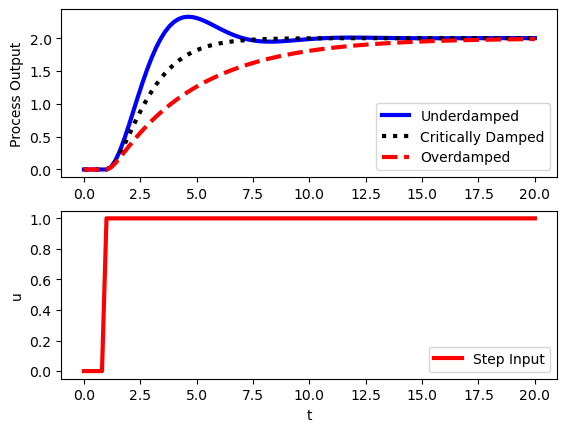

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# specify number of steps
ns = 100
# define time points
t = np.linspace(0,ns/5.0,ns+1)

class model(object):
    # default process model
    Kp = 2.0
    taus = 1.0
    thetap = 0.0
    zeta = 1.0

def process(x,t,u,Kp,taus,zeta):
    # Kp = process gain
    # taus = second order time constant
    # zeta = damping factor
    # ts^2 dy2/dt2 + 2 zeta taus dydt + y = Kp u(t-thetap)
    y = x[0]
    dydt = x[1]
    dy2dt2 = (-2.0*zeta*taus*dydt - y + Kp*u)/taus**2
    return [dydt,dy2dt2]

def calc_response(t,m):
    # t = time points
    # m = process model
    Kp = m.Kp
    taus = m.taus
    thetap = m.thetap
    zeta = m.zeta

    print('Kp: ' + str(Kp))
    print('taus: ' + str(taus))
    print('zeta: ' + str(zeta))

    # specify number of steps
    ns = len(t)-1
    delta_t = t[1]-t[0]

    # storage for recording values
    op = np.zeros(ns+1)  # controller output
    pv = np.zeros((ns+1,2))  # process variable

    # step input
    op[5:]=1.0

    # Simulate time delay
    ndelay = int(np.ceil(thetap / delta_t)) 

    # loop through time steps    
    for i in range(0,ns):
        # implement time delay
        iop = max(0,i-ndelay)
        inputs = (op[iop],Kp,taus,zeta)
        y = odeint(process,pv[i],[0,delta_t],args=inputs)
        pv[i+1] = y[-1]
    return (pv,op) 

# overdamped step response
model.zeta = 2.0
(pv1,op1) = calc_response(t,model)

# critically damped step response
model.zeta = 1.0
(pv2,op2) = calc_response(t,model)

# underdamped step response
model.zeta = 0.5
(pv3,op3) = calc_response(t,model)

plt.figure(1)

plt.subplot(2,1,1)
plt.plot(t,pv3[:,0],'b-',linewidth=3,label='Underdamped')
plt.plot(t,pv2[:,0],'k:',linewidth=3,label='Critically Damped')
plt.plot(t,pv1[:,0],'r--',linewidth=3,label='Overdamped')
plt.legend(loc='best')
plt.ylabel('Process Output')

plt.subplot(2,1,2)
plt.plot(t,op1,'r-',linewidth=3,label='Step Input')
plt.legend(loc='best')
plt.ylabel('u')

plt.xlabel('t')

plt.savefig('output.png')
plt.show()

## Análise gráfica
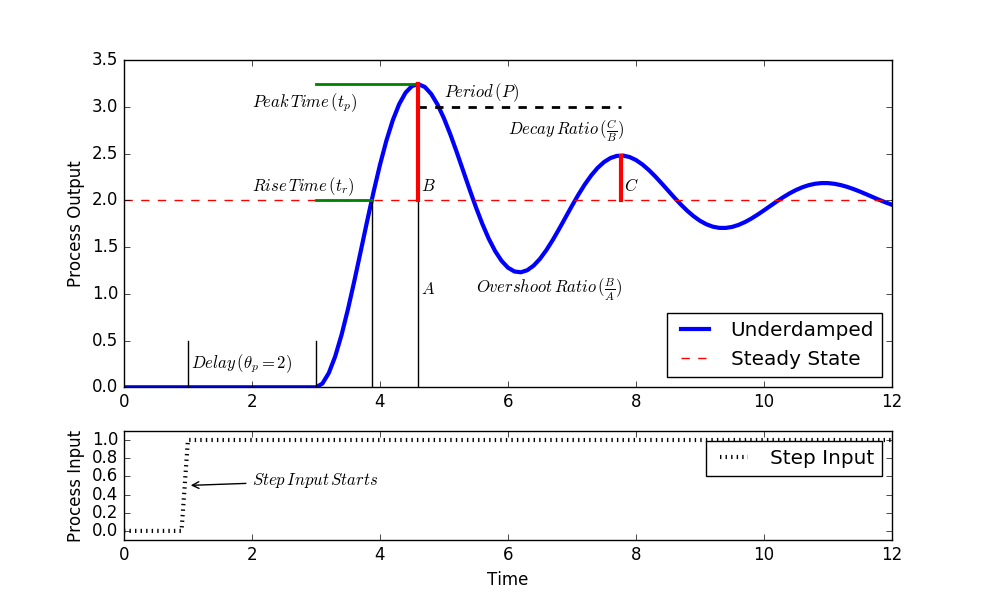
Rise time
$$t_r = \frac{\tau_s}{\sqrt{1-\zeta^2}}\left( \pi - cos^{-1} \zeta \right)$$
Peak time
$$t_p = \frac{\pi \tau_s}{\sqrt{1-\zeta^2}} \quad \quad \tau_s = \frac{\sqrt{1-\zeta^2}}{\pi}t_p$$
Overshoot ratio
$$OS = \exp\left({-\frac{\pi \zeta}{\sqrt{1-\zeta^2}}}\right) \quad \quad \zeta = \sqrt{\frac{\left(\ln(OS)\right)^2}{\pi^2 + \left(\ln(OS)\right)^2}}$$
Decay ratio:
$$DR = OS^2 = \exp\left({-\frac{2 \pi \zeta}{\sqrt{1-\zeta^2}}}\right)$$
Period:
$$P = \frac{2 \pi \tau_s}{\sqrt{1-\zeta^2}} \quad \quad \tau_s = \frac{\sqrt{1-\zeta^2}}{2 \pi}P$$


## Análise de ajuste teórico multi-parametro (métodos dos mínimos quadrados): 
cf https://apmonitor.com/pdc/index.php/Main/SecondOrderOptimization

### Referências: 
__[[1]](https://apmonitor.com/pdc/index.php/Main/SecondOrderSystems)__ ,
__[[2]](https://apmonitor.com/pdc/index.php/Main/SecondOrderGraphical)__, 
__[[3]](https://apmonitor.com/pdc/index.php/Main/SecondOrderOptimization)__ 